# COVID19 CHest X-Ray Detector

### When using in Google Colab, mounts Google Drive to access the data

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
#%cd '/content/drive/My Drive/COVID_Chest_X_Ray_Data/COVID19-Data'

### Importing all dependencies and libraries

In [1]:
from __future__ import print_function, division
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix, roc_curve

from keras.callbacks import EarlyStopping

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import pandas as pd

Using TensorFlow backend.


In [6]:
import cv2 

In [179]:
from io import BytesIO
from PIL import Image

In [2]:
import boto3
from sagemaker import get_execution_role
role = get_execution_role()

In [3]:
conn = boto3.client('s3')
covid = conn.list_objects(Bucket='amir-img', Prefix='COVID19-Data/Chest_COVID/')['Contents']
noncovid = conn.list_objects(Bucket='amir-img', Prefix='COVID19-Data/Chest_NonCOVID/')['Contents']

covid_files = [f['Key'] for f in covid]
noncovid_files = [f['Key'] for f in noncovid]

In [4]:
# Data size for both of the labels
print(len(covid_files), len(noncovid_files))

435 505


In [7]:
covid_labels = []
noncovid_labels = []

covid_images=[]
noncovid_images=[]

for f in covid:
    key = f['Key']
    name = key.split('/')[-1]
    #conn.download_file('amir-img', f['Key'], name)
    image = cv2.imread(name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(224,224))
    covid_images.append(image)
    covid_labels.append('Chest_COVID')
    
for f in noncovid:
    key = f['Key']
    name = key.split('/')[-1]
    #conn.download_file('amir-img', f['Key'], name)
    image = cv2.imread(name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(224,224))
    noncovid_images.append(image)
    noncovid_labels.append('Chest_COVID')

In [8]:
print(len(covid_images))
print(len(noncovid_images))

435
505


In [ ]:
# Preparing Labels
# covid_labels = []
# noncovid_labels = []

# covid_images=[]
# noncovid_images=[]

# for i, f in enumerate(covid):
#     print(i, end='') 
#     obj = conn.get_object(Bucket='amir-img', Key=f['Key'])
#     pil_img = Image.open(BytesIO(obj["Body"].read()))
#     image = np.array(pil_img) 
#     print(image.shape)
#     # Convert RGB to BGR 
#     image = image[:, :, ::-1].copy() 
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     image = cv2.resize(image,(224,224))
#     covid_images.append(image)
#     covid_labels.append('Chest_COVID')
    
# for f in noncovid:
#     obj = conn.get_object(Bucket='amir-img', Key=f['Key'])
#     str = obj["Body"].read()
#     pil_img = Image.open(BytesIO(str))
#     image = np.array(pil_img) 
#     # Convert RGB to BGR 
#     image = image[:, :, ::-1].copy() 
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     image = cv2.resize(image,(224,224))
#     noncovid_images.append(image)
#     noncovid_labels.append('Chest_NonCOVID')

In [101]:
#https://amir-img.s3.us-west-2.amazonaws.com/COVID19-Data/
#s3://amir-img/COVID19-Data/    
#cv2.imread('01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg0')

### Defines some model parameters

In [9]:
#define size to which images are to be resized
IMAGE_SIZE = [224, 224] # can be changed depending on the dataset

# training config:
epochs = 250
batch_size = 32

### Quick glimpse of the data set

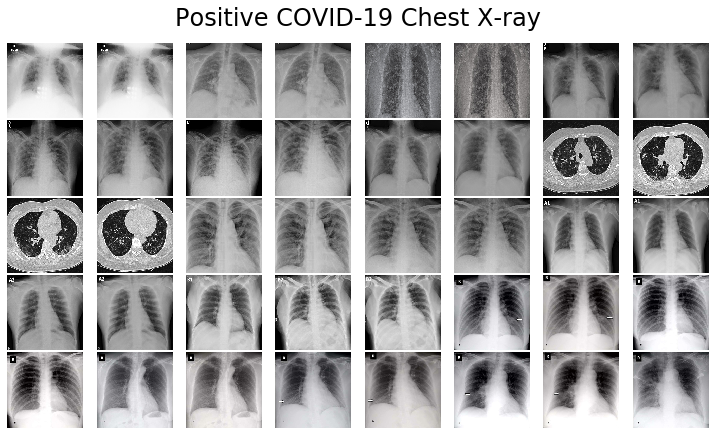

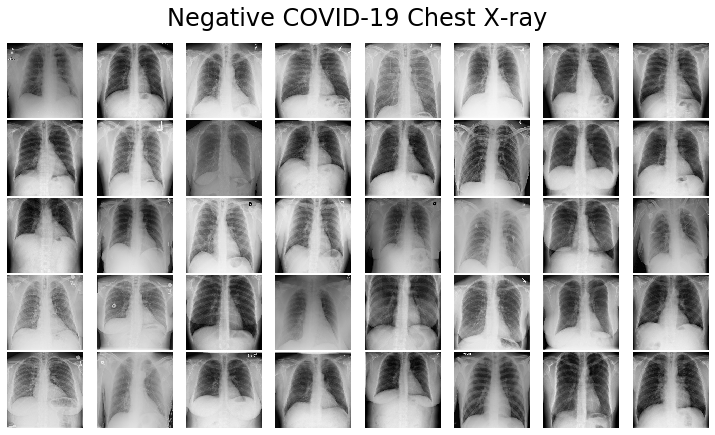

In [10]:
# look at a random image for fun
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(covid_images, 'Positive COVID-19 Chest X-ray')
plot_images(noncovid_images, 'Negative COVID-19 Chest X-ray')

In [11]:
# Convert to array and Normalize to interval of [0,1]
covid_images = np.array(covid_images) / 255
noncovid_images = np.array(noncovid_images) / 255

In [12]:
print(covid_images.shape)
print(noncovid_images.shape)

(435, 224, 224, 3)
(505, 224, 224, 3)


### Split data set into training and testing

In [13]:
# split into training and testing
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(covid_images, covid_labels, test_size=0.2)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(noncovid_images, noncovid_labels, test_size=0.2)

In [15]:
covid_x_train.shape

(348, 224, 224, 3)

In [14]:
X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

MemoryError: Unable to allocate 864. MiB for an array with shape (752, 224, 224, 3) and data type float64

In [ ]:
print(X_train.shape)

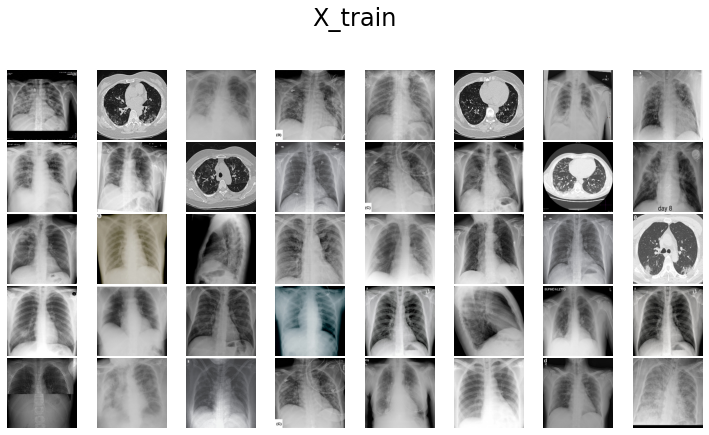

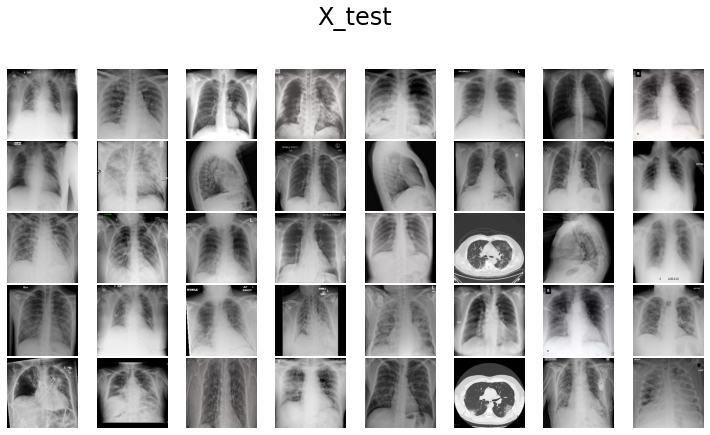

In [22]:
plot_images(covid_x_train, 'X_train')
plot_images(covid_x_test, 'X_test')
# y_train and y_test contain class lables 0 and 1 representing COVID and NonCOVID for X_train and X_test

### Importing the Model

In [23]:
vggModel = VGG19(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = vggModel.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=vggModel.input, outputs=outputs)

for layer in vggModel.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

80150528/80134624 [==============================] - 12s 0us/step


In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [26]:
train_augmented = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

### Training!

In [29]:
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [30]:
history = model.fit(train_augmented.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    epochs=25,
                    callbacks=[es])

Epoch 1/25
23/23 [==============================] - 122s 5s/step - loss: 0.8784 - accuracy: 0.5918 - val_loss: 0.4579 - val_accuracy: 0.7979
Epoch 2/25
 3/23 [==>...........................] - ETA: 1:20 - loss: 0.7303 - accuracy: 0.6667

KeyboardInterrupt: 

### Model export

In [ ]:
model.save('/content/vgg_chest.h5')

In [ ]:
model.save('/content/drive/My Drive/COVID_Chest_X_Ray_Data/covid_vgg_chest.h5')

In [ ]:
model.save_weights('/content/drive/My Drive/COVID_Chest_X_Ray_Data/covid_vgg_chest_weights.hdf5')

In [ ]:
model = load_model('/content/vgg_chest.h5')

### Results and analysis

In [ ]:
y_pred = model.predict(X_test, batch_size=batch_size)

In [ ]:
y_pred[0:10]

array([[2.8064970e-03, 9.9719352e-01],
       [1.2600198e-02, 9.8739982e-01],
       [4.7659183e-01, 5.2340817e-01],
       [4.4601254e-02, 9.5539874e-01],
       [8.2665216e-04, 9.9917334e-01],
       [3.5053182e-03, 9.9649471e-01],
       [3.6613062e-01, 6.3386935e-01],
       [3.5624584e-04, 9.9964380e-01],
       [8.1245258e-04, 9.9918753e-01],
       [8.7634671e-01, 1.2365327e-01]], dtype=float32)

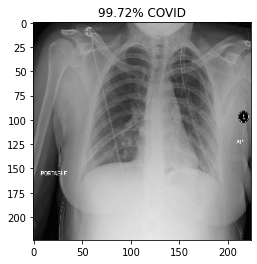

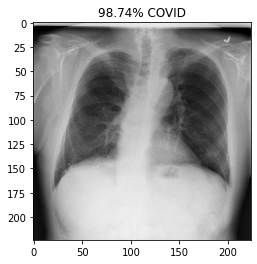

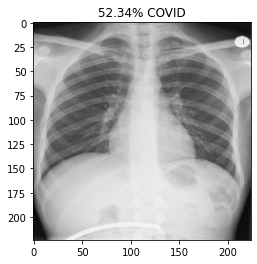

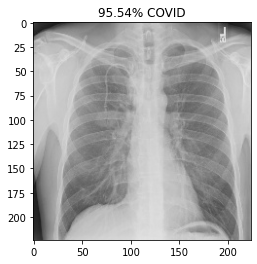

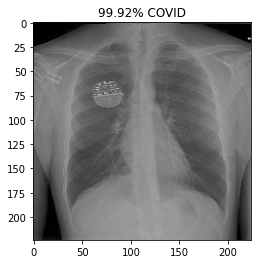

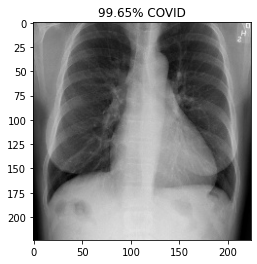

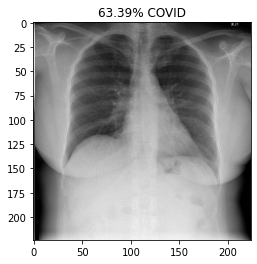

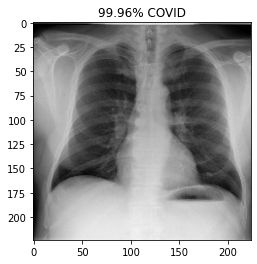

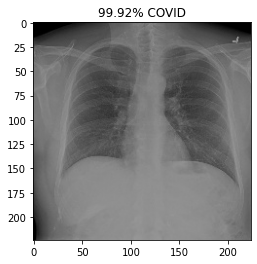

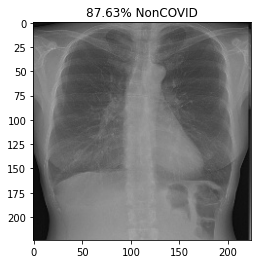

In [ ]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
    if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID')
    else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
    plt.imshow(X_test[index])
    plt.show()

In [ ]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

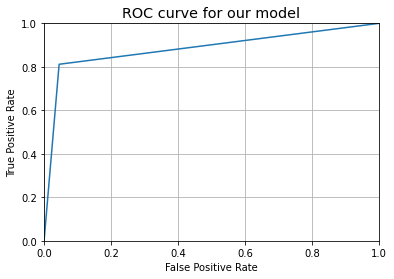

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

Confusion Matrix without Normalization


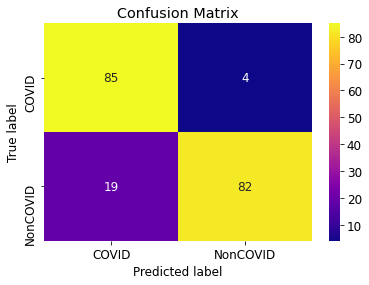

Confusion Matrix with Normalized Values


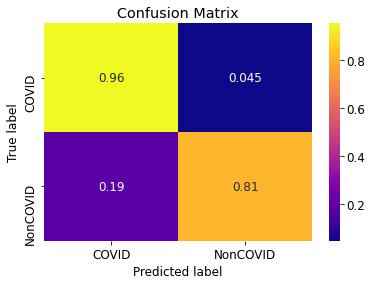

In [ ]:
def plot_confusion_matrix(normalize):
    classes = ['COVID','NonCOVID']
    tick_marks = [0.5,1.5]
    cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
    sns.heatmap(cn,cmap='plasma',annot=True)
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

In [ ]:
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.82      0.96      0.88        89
           1       0.95      0.81      0.88       101

    accuracy                           0.88       190
   macro avg       0.89      0.88      0.88       190
weighted avg       0.89      0.88      0.88       190



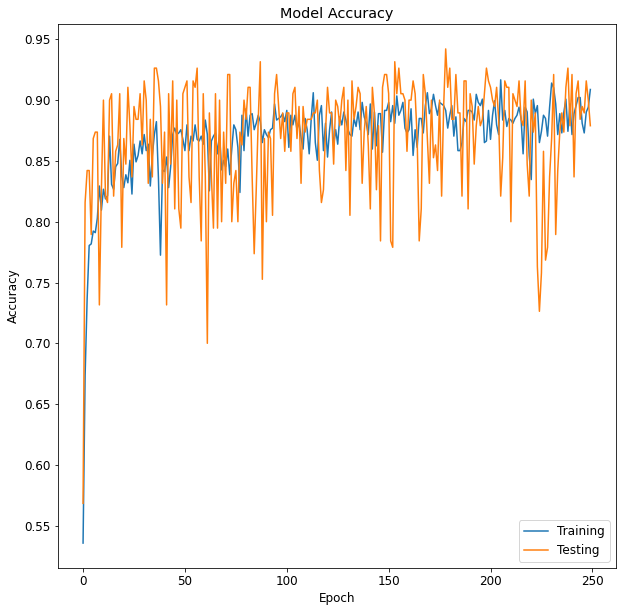

In [ ]:
plt.figure(figsize=(10,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_chest_accuracy.png')
plt.show()

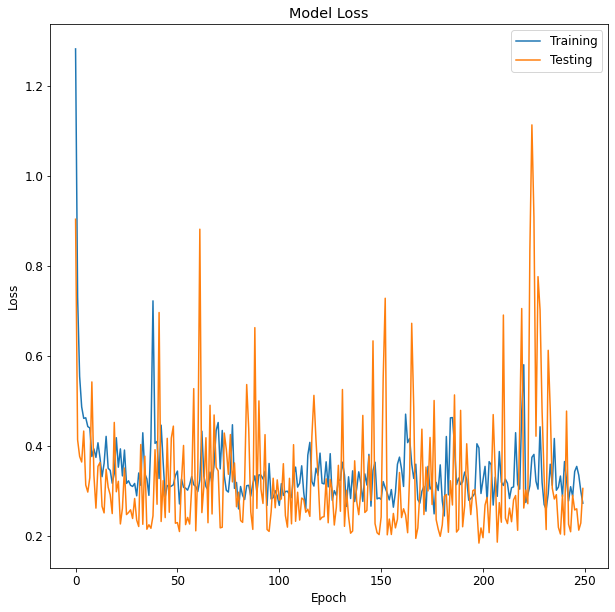

In [ ]:
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_chest_loss.png')
plt.show()

In [ ]:
img_path = '/content/drive/My Drive/COVID_Chest_X_Ray_Data/Chest_COVID/01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg'
img_glob = glob(img_path)
img_glob

['/content/drive/My Drive/COVID_Chest_X_Ray_Data/Chest_COVID/01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg']

In [ ]:
image = cv2.imread(img_glob[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image,(224,224))
image

array([[[133, 133, 133],
        [122, 122, 122],
        [115, 115, 115],
        ...,
        [134, 134, 134],
        [133, 133, 133],
        [254, 254, 254]],

       [[106, 106, 106],
        [ 93,  93,  93],
        [ 88,  88,  88],
        ...,
        [126, 126, 126],
        [124, 124, 124],
        [254, 254, 254]],

       [[ 55,  55,  55],
        [ 46,  46,  46],
        [ 48,  48,  48],
        ...,
        [121, 121, 121],
        [116, 116, 116],
        [254, 254, 254]],

       ...,

       [[247, 247, 247],
        [243, 243, 243],
        [242, 242, 242],
        ...,
        [215, 215, 215],
        [209, 209, 209],
        [254, 254, 254]],

       [[245, 245, 245],
        [243, 243, 243],
        [242, 242, 242],
        ...,
        [216, 216, 216],
        [213, 213, 213],
        [254, 254, 254]],

       [[245, 245, 245],
        [243, 243, 243],
        [242, 242, 242],
        ...,
        [217, 217, 217],
        [214, 214, 214],
        [254, 254, 254]]

In [ ]:
image = np.array(image)/255
image

array([[[0.52156863, 0.52156863, 0.52156863],
        [0.47843137, 0.47843137, 0.47843137],
        [0.45098039, 0.45098039, 0.45098039],
        ...,
        [0.5254902 , 0.5254902 , 0.5254902 ],
        [0.52156863, 0.52156863, 0.52156863],
        [0.99607843, 0.99607843, 0.99607843]],

       [[0.41568627, 0.41568627, 0.41568627],
        [0.36470588, 0.36470588, 0.36470588],
        [0.34509804, 0.34509804, 0.34509804],
        ...,
        [0.49411765, 0.49411765, 0.49411765],
        [0.48627451, 0.48627451, 0.48627451],
        [0.99607843, 0.99607843, 0.99607843]],

       [[0.21568627, 0.21568627, 0.21568627],
        [0.18039216, 0.18039216, 0.18039216],
        [0.18823529, 0.18823529, 0.18823529],
        ...,
        [0.4745098 , 0.4745098 , 0.4745098 ],
        [0.45490196, 0.45490196, 0.45490196],
        [0.99607843, 0.99607843, 0.99607843]],

       ...,

       [[0.96862745, 0.96862745, 0.96862745],
        [0.95294118, 0.95294118, 0.95294118],
        [0.94901961, 0

(224, 224, 3)


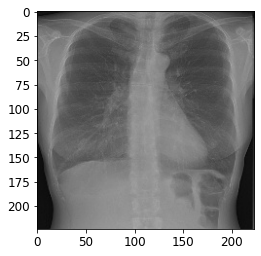

In [ ]:
print(image.shape)
plt.imshow(X_test[index])
plt.show()

In [ ]:
test = np.array([image, image, image])
test = np.concatenate((test, test), axis=0)

In [ ]:
result = model.predict(test, batch_size=batch_size)

In [ ]:
result

array([[9.999920e-01, 7.953868e-06],
       [9.999920e-01, 7.953868e-06],
       [9.999920e-01, 7.953868e-06],
       [9.999920e-01, 7.953868e-06],
       [9.999920e-01, 7.953868e-06],
       [9.999920e-01, 7.953868e-06]], dtype=float32)

In [ ]:
for index, probability in enumerate(result):
    if probability[1] > 0.5:
        print('%.2f' % (probability[1]*100) + '% COVID')
    else:
        print('%.2f' % ((1-probability[1])*100) + '% NonCOVID')

100.00% NonCOVID
100.00% NonCOVID
100.00% NonCOVID
100.00% NonCOVID
100.00% NonCOVID
100.00% NonCOVID


In [ ]:
print("Ready")

In [ ]:
test_vggModel = VGG19(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))
test_vggModel.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     